In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import functions.eddy_feedback as ef
import functions.data_wrangling as data

## Import data

In [2]:
path = Path('/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded')
data_files = sorted(path.glob('*.nc'))

model_names = []
for item in data_files:
    
    file_stem = item.stem
    model = file_stem.split('_')[0]
    model_names.append(model)

ds = {}
for model in model_names:
    
    data_path = path / f'{model}_1.1_ubar_epfy_divFy.nc'
    
    dataset = xr.open_dataset(str(data_path))
    ds[model] = dataset

In [3]:
efp = {'model': [], 'efp_nh': [], 'efp_sh': []}

for model in model_names:
    efp_value_nh = ef.calculate_efp(ds[model], data_type='pamip')
    efp_value_sh = ef.calculate_efp(ds[model], data_type='pamip', calc_south_hemis=True)
    efp['model'].append(model)
    efp['efp_nh'].append(efp_value_nh)
    efp['efp_sh'].append(efp_value_sh)

df = pd.DataFrame(efp)

In [4]:
df['neck_wind_nh'] = np.nan
df['neck_wind_sh'] = np.nan
df

,model,efp_nh,efp_sh,neck_wind_nh,neck_wind_sh
0,CESM1-WACCM-SC,0.1297,0.0295,NaN,NaN
1,CESM2,0.3693,0.3419,NaN,NaN
2,CNRM-CM6-1,0.2421,0.2082,NaN,NaN
3,CanESM5,0.4256,0.4618,NaN,NaN
4,E3SMv1,0.0543,0.0542,NaN,NaN
5,EC-EARTH3,0.2945,0.3135,NaN,NaN
6,ECHAM6.3,0.0139,0.0103,NaN,NaN
7,FGOALS-f3-L,0.2354,0.1274,NaN,NaN
8,HadGEM3-GC31-LL,0.2730,0.2951,NaN,NaN
9,HadGEM3-GC31-MM,0.3137,0.3002,NaN,NaN


In [5]:
neck_winds = {}
for model in model_names:
    
    for hem in ['sh', 'nh']:
    
        # Handle ensembles if present
        if 'ens_ax' in ds[model].dims:
            ubar = ds[model].ubar.mean('ens_ax')
            ubar = data.seasonal_mean(ubar, season='djf')
        else:  # Handle datasets with ensembles as separate years
            ubar = ds[model].ubar
            ubar = data.seasonal_mean(ubar, season='djf')
            ubar = ubar.mean('time')
        
        if hem == 'sh':
            u_neck = ubar.sel(level=70, method='nearest').sel(lat=slice(-55,-45)).mean('lat')
        else:
            u_neck = ubar.sel(level=70, method='nearest').sel(lat=slice(45,55)).mean('lat')

        df.loc[df['model'] == model, f'neck_wind_{hem}'] = np.mean(u_neck.values).round(3)

In [6]:
df = df[df["model"] != "ECHAM6.3"]
df = df[df["model"] != "E3SMv1"]
df = df[df["model"] != "CESM1-WACCM-SC"]
df

,model,efp_nh,efp_sh,neck_wind_nh,neck_wind_sh
1,CESM2,0.3693,0.3419,17.052000,15.938000
2,CNRM-CM6-1,0.2421,0.2082,13.709000,8.304000
3,CanESM5,0.4256,0.4618,22.422001,16.708000
5,EC-EARTH3,0.2945,0.3135,15.677000,9.815000
7,FGOALS-f3-L,0.2354,0.1274,14.620000,7.875000
8,HadGEM3-GC31-LL,0.2730,0.2951,22.396999,16.663000
9,HadGEM3-GC31-MM,0.3137,0.3002,21.104000,14.212000
10,IPSL-CM6A-LR,0.2719,0.1959,18.520000,14.349000
11,MIROC6,0.2213,0.3253,14.505000,11.710000
12,NorESM2-LM,0.3238,0.3754,19.240000,18.490999


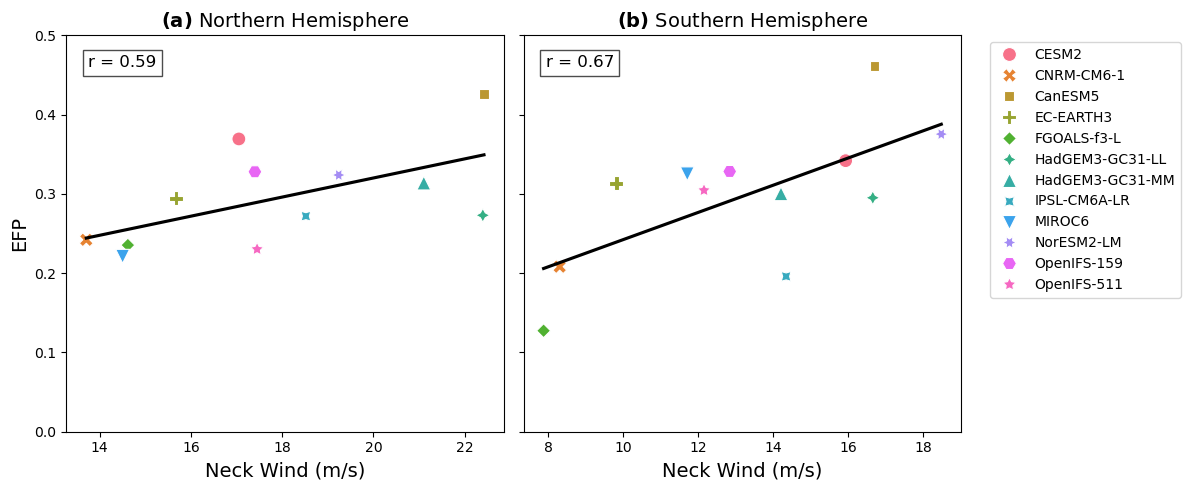

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5), sharey=True)

# Function to compute and add Pearson correlation
def add_correlation(ax, x, y):
    corr, _ = pearsonr(x, y)  # Compute Pearson correlation
    ax.text(0.05, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
            fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7))

sns.scatterplot(
    x=df['neck_wind_nh'],
    y=df['efp_nh'],
    hue=df['model'],
    style=df['model'],
    s=100,
    ax=ax[0]
)
sns.regplot(
    x=df['neck_wind_nh'],
    y=df['efp_nh'],
    scatter=False,
    color='k',
    ci=None,
    ax=ax[0]
)
# Add correlation to the figure
add_correlation(ax[0], df['efp_nh'], df['neck_wind_nh'])
ax[0].legend_.remove()
ax[0].set_xlabel('Neck Wind (m/s)', fontsize=14)
ax[0].set_ylabel('EFP', fontsize=14)
ax[0].set_title('$\\bf{(a)}$ Northern Hemisphere', fontsize=14)


sns.scatterplot(
    x=df['neck_wind_sh'],
    y=df['efp_sh'],
    hue=df['model'],
    style=df['model'],
    s=100,
    ax=ax[1]
)
sns.regplot(
    x=df['neck_wind_sh'],
    y=df['efp_sh'],
    scatter=False,
    color='k',
    ci=None,
    ax=ax[1]
)
# Add correlation to the figure
add_correlation(ax[1], df['efp_sh'], df['neck_wind_sh'])
ax[1].set_xlabel('Neck Wind (m/s)', fontsize=14)
ax[1].set_ylabel('EFP', fontsize=14)
ax[1].set_title('$\\bf{(b)}$ Southern Hemisphere', fontsize=14)

# Add legend and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0,0.5)

plt.tight_layout()
plt.savefig('./plots/neck_wind_efp.png', bbox_inches='tight')
plt.show()